In [1]:
import pandas as pd
import csv, gzip, json
import seaborn as sb
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import glob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import digits
import re
from random import seed
import os, gzip, json
from itertools import islice, izip
import codecs
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
import scipy as sp
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [14]:
frame = pd.read_csv('./cooc_bymonth/2017_01.csv', header=None, names=['author', 'subreddit', 'name', 'parent_id'])

### Take test authors to be compared with

In [42]:
u1 = pd.read_csv('./tenplus/2016_11_final.csv', header=None, names=['idex', 'author', 'count'])
u2 = pd.read_csv('./tenplus/2016_12_final.csv', header=None, names=['idex', 'author', 'count'])
test = pd.read_csv('./tenplus/2017_01_final.csv', header=None, names=['idex', 'author', 'count'])

In [43]:
bondwith = list(set(u1['author'].tolist()).union(set(u2['author'])))
bondsofhigh = test.loc[test['count'] >= np.percentile(np.array(test['count']), 75), 'author']
bondsoflow = test.loc[test['count'] <= np.percentile(np.array(test['count']),25) ,'author']

## Take only author and subreddit info from the frame

In [44]:
user_cooc = frame[['author', 'subreddit']].copy()

In [45]:
user_cooc = user_cooc.drop_duplicates()

In [46]:
user_cooc.to_csv('./usersubembedding.gz', sep=',', compression='gzip')

## Create cooccurence matrix

In [47]:
dense_source = './usersubembedding.gz'

user_map = dict()
sub_map = dict()
user_idx = 0
sub_idx = 0
reverse_sub_map = dict()
p_sparse = defaultdict(lambda: Counter())
test_counter = 0

with gzip.open(dense_source, 'r') as gfile:
    for line in gfile:
        test_counter+=1
        if test_counter==1:
            pass
        pair = line.strip().split(',')
        if pair[1] not in user_map:
            user_map[pair[1]] = user_idx
            reverse_sub_map[user_idx] = pair[1]
            user_idx +=1
        if pair[2] not in sub_map:
            sub_map[pair[2]] = sub_idx
            sub_idx +=1
        p_sparse[sub_map[pair[2]]][user_map[pair[1]]] +=1

In [48]:
p_sparse

defaultdict(<function __main__.<lambda>>,
            {0: Counter({0: 1, 6614: 1}),
             1: Counter({1: 1,
                      11: 1,
                      30: 1,
                      33: 1,
                      37: 1,
                      40: 1,
                      45: 1,
                      46: 1,
                      56: 1,
                      63: 1,
                      64: 1,
                      67: 1,
                      70: 1,
                      93: 1,
                      123: 1,
                      126: 1,
                      139: 1,
                      148: 1,
                      158: 1,
                      160: 1,
                      169: 1,
                      178: 1,
                      179: 1,
                      188: 1,
                      189: 1,
                      205: 1,
                      218: 1,
                      219: 1,
                      234: 1,
                      243: 1,
                      244: 1

## Create cooccurence sqaure for PMI calculation

In [49]:
cooccurrences = Counter()
cooccurrences_arr, user_arr, sub_arr = zip(*[(count, user, sub) for sub, d in p_sparse.iteritems() for user, count in d.iteritems()])
cooccurrences = csr_matrix((np.ones_like(cooccurrences_arr), (user_arr, sub_arr)))
del cooccurrences_arr, sub_arr, user_arr
cooccurrences_square = cooccurrences.dot(cooccurrences.T)
cooccurrences_square

<6615x6615 sparse matrix of type '<type 'numpy.int64'>'
	with 40559897 stored elements in Compressed Sparse Row format>

## Calculate PMI and PPMI

In [50]:
cooccurrences_square = cooccurrences_square.todense()
pxy = cooccurrences_square/float(cooccurrences_square.sum())
px = py = pxy.sum(axis=0)
pmi = np.log2(np.divide(pxy, np.outer(px.T, py)))
ppmi = pmi.copy()
print np.max(np.max(pmi))
print np.min(np.min(pmi))
ppmi[ppmi < 0.] = 0.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


24.6624583941
-inf


In [51]:
print("%d bytes" % (ppmi.size * ppmi.itemsize))

350065800 bytes


In [52]:
from bokeh.io import output_notebook
output_notebook()


Loading BokehJS ...

## dimensionality reduction with PCA and plotting first two dimensions for vis

In [53]:
pca = PCA( random_state=0)
ppmi_2d = pca.fit_transform(ppmi) 

Populating the interactive namespace from numpy and matplotlib
0.59729363605
[ 0.3834353   0.11291627  0.04217648  0.03414488  0.02462071]


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['viridis', 'figure', 'size', 'show', 'source', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


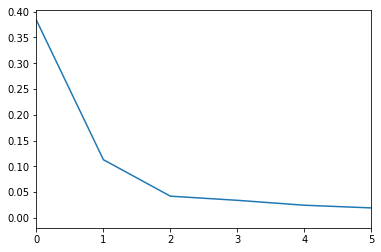

In [54]:
%pylab inline
ax=plot(pca.explained_variance_ratio_)
gca().set_xlim((0, 5))

print pca.explained_variance_ratio_[:5].sum()
print pca.explained_variance_ratio_[:5]
user_rmap = {j:i for i, j in user_map.iteritems()}

import bokeh.models as bmo
from bokeh.palettes import d3, viridis

from bokeh.models import HoverTool, LabelSet
from bokeh.plotting import figure, show, ColumnDataSource
# from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label

x = ppmi_2d[:, 0]
y = ppmi_2d[:, 1]
author_names = [i[0][:-4] for i in sorted(user_map.iteritems(), key=lambda (x, y):y)]
author_colors = []
for name in author_names:
    if name in bondsofhigh:
        author_colors.append('#ff0000')
    elif name in bondsoflow:
        author_colors.append('##00008b')
    else:
        author_colors.append('#228b22')
    

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = cooccurrences.sum(axis=1).getA1()
radii = [np.log(size) * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            author_color=author_colors,
            radii=radii
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes")
        
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'], plot_width=1000, plot_height=1000)
p.scatter('x', 'y', radius='radii', fill_color='author_color', source=source, 
          fill_alpha=0.3, line_color=None)
# labels = LabelSet(x='x', y='y', text='author_names', level='glyph',
#               x_offset=0, y_offset=0, source=source, render_mode='canvas', text_font_size="6pt")
# p.add_layout(labels)

show(p)

In [33]:
import numpy as np

from bokeh.plotting import figure, show, output_file

N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x, y, radius=radii,
          fill_color=colors, fill_alpha=0.6,
          line_color=None)

output_file("color_scatter.html", title="color_scatter.py example")

show(p)  # open a browser


In [34]:
print colors

['#401f96', '#6a5396', '#569396', '#5c2296', '#8da696', '#838796', '#3aad96', '#d6d296', '#bfc696', '#879696', '#864896', '#62de96', '#bf5596', '#944296', '#f29396', '#da6196', '#ca3596', '#62ce96', '#3f2096', '#bc2796', '#3f7396', '#619896', '#c9de96', '#9f9a96', '#888796', '#9dbb96', '#359d96', '#474c96', '#dc4e96', '#32c696', '#e9ac96', '#7a9396', '#d3e296', '#9b2096', '#df8e96', '#8e2596', '#e12a96', '#d2bf96', '#483396', '#b2cf96', '#e8b296', '#87cf96', '#819e96', '#8e7696', '#4e4296', '#e84196', '#809d96', '#8cce96', '#df9496', '#b99496', '#c1c196', '#384c96', '#4f2496', '#522f96', '#4fe096', '#daa796', '#d05996', '#f15896', '#722596', '#d64096', '#a07196', '#3ac996', '#397396', '#a83f96', '#5c2796', '#999696', '#544896', '#568e96', '#afb596', '#359896', '#ab7996', '#65a096', '#49e596', '#82e296', '#4d7796', '#adb896', '#808596', '#9bb196', '#7f6e96', '#d5a596', '#b0d096', '#815396', '#89b996', '#bf5a96', '#f88996', '#71cf96', '#e65796', '#3fb396', '#c23796', '#e12296', '#536d96'